<a href="https://colab.research.google.com/github/okweipeng/Machine-Learning-for-Music-Classification-.MIDI-/blob/main/CST4702_(ML)_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Machine Learning for Music Classification***

#### **CST4702 Final Project**




#### **Imports to be utilized**

In [ ]:
# Import necessary libraries
import numpy as np
# Mounting drive onto colab; for neat file reading (all in one folder; six composers)
from google.colab import drive
# Utilization of library of music21 and its tools; meaningful attributes/feature extracting
from music21 import converter, note, chord, interval, midi, tempo
# Libraries of sklearn for my choosen machine learning models and overall performance evalutation
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
# To present the overall visuals including the comparsion of all models and there confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
# Imports used to allow the tracking of the overall evualation of timing and memory usage
import tracemalloc
import time
# Ignore outputted warning; enable more viewing
import warnings

In [ ]:
# Ignore any warning in regards to MIDI files
warnings.filterwarnings("ignore", category=midi.translate.TranslateWarning)

#### **To advance foward; please do the next following:**

**Note:** To run the following block of codes; please. first have this on your google drive (My Drive) to advance foward as it provides the 6 composers & mid files:

**Please See:**

With the following drive link provided; it consist of the 6 composers and its mid/midi files:

https://drive.google.com/drive/folders/1l_EGBktIGjNO3djMq-HYJ11nEgeNvTa_?usp=drive_link

#### **For your information: selected composers**

**Composers Selection:**  

Danzi; total of 36 MIDI files

Delibes; total of 26 MIDI files

Cima; total of 62 MIDI files

Chaumont; total of 47 MIDI files

Brade; total of 93 MIDI files

Campra; total of 14 MIDI files

**Total of 278 MIDI files**


#### **Mount/Connect to your Google Drive after**

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Folder path for MIDI files
folder_path = '/content/drive/My Drive/MIDI_Dataset'

Mounted at /content/drive


**To be known:** *the google drive link above consist of the following chosen composers; (including brade, campra, chaumont, cima, danzi, & delibe) with its corresponding MID files*

#### **Loading in the files (consist of 6 composers with its corresponding files)**

In [ ]:
# Define load_midi_files to read MIDI files of six composers
def load_midi_files(folder_path):

# Create an empty list to store composers and its correpsonding files
    data, labels = [], []
    # Verify the files, iterates the files within my specificed folder path; ensuring files are stored correctly
    for composer in os.listdir(folder_path):
        composer_path = os.path.join(folder_path, composer)
        if os.path.isdir(composer_path):
        # Iterate files of such filing formats
            for file in os.listdir(composer_path):
                if file.endswith('.mid') or file.endswith('.midi'):
                    file_path = os.path.join(composer_path, file)
                     # Parse MIDI file into a Stream object
                    midi = converter.parse(file_path)
                    data.append(midi)
                    labels.append(composer)

    return data, labels

Reads in the MID files the google drive folder (with link provided) and organizes them.

Iterates through all the available folders named of the composers (total of 6), processes only the files with .mid and converts each MID file into a format the program can understand (using music21). Each file of its corresponding composer is saved as a label.

#### **Preprocessing MIDI files/composer datasets**

In [ ]:
# Define preprocess_midi to preprocess the neccesary files to be used and discard/filtering out the outliers
def preprocess_midi(midi_data, min_elements=10):

    # Create empty list to store the preprocess files/dataset
    preprocessed_data = []

# Iterate through MIDI files, using the flatten() function to achieves its features (e.g. notes, etc.)
    for midi in midi_data:  # Go through each MIDI file
        flat_midi = midi.flatten()

        # In this case we wil take in thesee componenets to incremenet the filtering on outliers; files differ from others in component wise
        stored_components = [component for component in flat_midi if isinstance(component, (note.Note, chord.Chord))]
        if len(stored_components) < min_elements:
            print("Skip")
            continue
            # To ensure valid component wise; MIDI file to the list
        preprocessed_data.append(flat_midi)

    return preprocessed_data  # Return the cleaned files

This function processes each MIDI file by flattening its structure to extract individual musical elements like notes and chords. It filters out files that don't meet a minimum threshold of musical elements, ensuring only meaningful data is retained. The cleaned and processed files are then returned for further analysis.

#### **Load the files & show the 6 chosen composer**

(This may be time consuming to be ran); estimate of 10 minutes needed

In [ ]:
# Iterate through the folder of stored composers (later output the after total files; filter and provide the composer names)
midi_data, labels = load_midi_files(folder_path)

# Display the number of loaded MID files and the unique composers
print(f"Loaded {len(midi_data)} MIDI files from {len(set(labels))} composers.")
print(f"Composers: {', '.join(set(labels))}")

Loaded 266 MIDI files from 6 composers.
Composers: delibes, danzi, chaumont, cima's, brade, campra


To provide the files to be loaded from the folder_path as specified in the beginning, provided the context to be printed when the MIDI has been loaded. Not only that, to make sure that the correct composers are loaded and ready for further analysis, I also made sure to have the composers identified.

In [ ]:
# Preprocess MIDI Data
preprocessed_midi_data = preprocess_midi(midi_data)
# Thus will see the total left/remaining of qualified files to use for ML model classifications
print(f"Preprocessed {len(preprocessed_midi_data)} MID files.")

Preprocessed 266 MID files.


Calling the preprocess_midi function, which filters and cleans MIDI files may affect the role of machine learning evaluation, or in other words, its performance. To ensure the best without the risk of having outlier files, I have filtered out MIDI (music) files that have too few elements. Therefore it will not affect the classification of our model training.

#### **Feature Extraction**

In [ ]:
# Defined a funtion on extracting midi features; the feature_extraction function
def features_extraction(midi_data):

# Created a empty list to store the features to be extracted
    features = []

# Iterating through all midi
    for midi in midi_data:
      # Creating a empty list to store the following features
        notes, durations, intervals = [], [], []
        key_signature = midi.analyze('key')
        last_pitch = None
# Iterating through the midi data (notes and chords), stroring meaningful attributes into an representation
        for element in midi.flatten().notes:
          # IF its a note then the note will be saved for further use
            if isinstance(element, note.Note):
               # Keep
                notes.append(str(element.pitch))
                # Keep feature
                durations.append(element.quarterLength)
                if last_pitch:
                    intervals.append(str(interval.Interval(last_pitch, element.pitch).name))
                last_pitch = element.pitch
                # If chord, keep
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(map(str, element.normalOrder)))
                durations.append(element.quarterLength)

        # Store the extracted features in a dictionary
        features.append({
            "notes": ' '.join(notes),
            "durations": ' '.join(map(str, durations)),
            "intervals": ' '.join(intervals),
            "key_signature": key_signature.tonic.name if key_signature else "Unknown",
            "tempo": midi.metronomeMarkBoundaries()[0][2].number if midi.metronomeMarkBoundaries() else 120
        })
    # Return the features in extraction
    return features

Utilizing/Initalizing preprocessed MIDI data and extracting important musical features such as notes, durations, and intervals between notes or chords. Though as overall, it ensures the machine learning models understand the MIDI file structure, which is more of a crucial part of the task, for classification.

In [ ]:
# Extract features
features = features_extraction(preprocessed_midi_data)
# An string of feature representation of extraction (the meaningful attributes)
combined_features = [
    ' '.join([f['notes'], f['durations'], f['intervals'], f['key_signature'], str(f['tempo'])])
    for f in features
]

Extracts the features (meaningful attributes) from the preprocessed MIDI files from the features_extraction function. The resulting features are stored as dictionaries for each MIDI file. The combination of features allows for our next vectorization from the text transformation. Thus, it is useful among selected machine learning models.

####**Vectorization (transform)**

In [ ]:
# Implemented CountVectorizer, generate n-grams (1 to 3) of selected selected going along
vectorizer = CountVectorizer(ngram_range=(1, 3))
# Transform the combined features into a matrix
X = vectorizer.fit_transform(combined_features)

# Using LabelEncoder; convert labels (composers) into numerical values
encoder = LabelEncoder()
y = encoder.fit_transform(labels)

As for an overall gist, utilizing the countvectorizer represents our text formated text, into a new representation, with the initial of numbers/matrix, allowing selected machine learning models to work with such a structured format.

#### **Train-test-split; machine learning model use wise**

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### **Model Evalation (performance of ML models)**

In [ ]:
# Define an function to evaluate the models performance
def evaluate_model(model, X_train, X_test, y_train, y_test):
  # Noting the start time of the model, thus records its training time
    start_time = time.time()
    # Modeling training
    model.fit(X_train, y_train)
     # Predict test labels
    y_pred = model.predict(X_test)
    # Evaluate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Provide an overview of the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Provide the evaluation of time it took the model to perform
    duration = time.time() - start_time

    # Thus return all
    return accuracy, cm, duration

Evaluating all machine learning model via the train_test_split functionn evaluate its performance on the test set. Determining the accuracy, confusion matrix, and the time taken, providing insights into the model's overall performance

### **Machine Learning Model Evaluation**

**Support Vector Machine (SVM)**

SVM Accuracy: 0.9259
SVM Training Time: 0.22 seconds
SVM Training Memory Usage: 18.64 MB (peak)


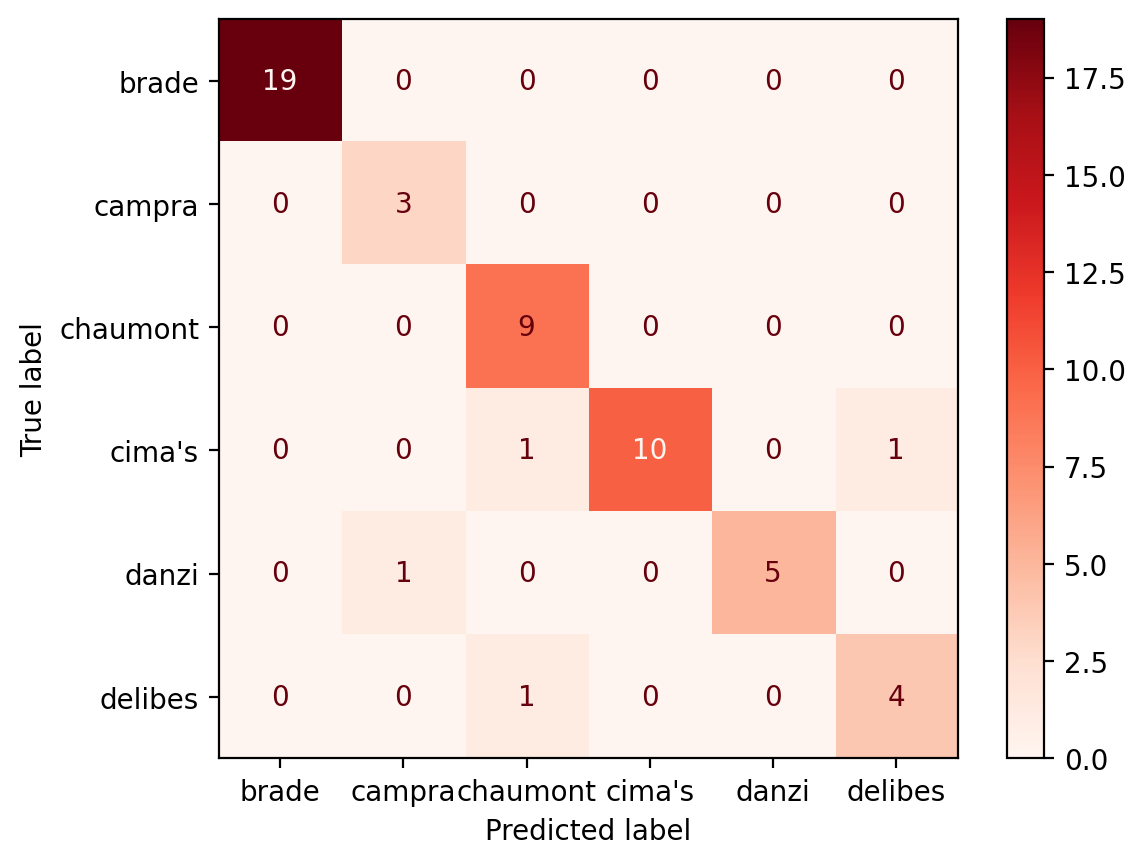

In [ ]:
# SVM Model
svm_model = SVC(kernel='linear', random_state=42)

# The measure of the overall model performance
# Thus to track the start and ending time of the model and its memory usage
# Note with the import of tracemalloc; it allows to track the training time for the model in use
start_time = time.time()
tracemalloc.start()
svm_model.fit(X_train, y_train)
training_time = time.time() - start_time
_, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
y_pred_svm = svm_model.predict(X_test)
# Thus, note that the import of tracemalloc allows time tracking of the performance based on model

# Model performance based on its accruacy; how well to its classifcation
svm_accuracy = svm_model.score(X_test, y_test)
# Provide an confusion matrix
svm_cm = confusion_matrix(y_test, y_pred_svm)

# Results to be provided in output
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"SVM Training Time: {training_time:.2f} seconds")
print(f"SVM Training Memory Usage: {peak / 10**6:.2f} MB (peak)")

# Visual of the CM (confusion matrix)
ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=encoder.classes_).plot(cmap="Reds")

**Visual Output Explanation:**

With this overall visual of confusion matrix specifically for Support Vector Machine, the way I’m looking at this matrix, on our true positive (TP), diagonally, and the outer predicted classes, there is a very minimal misclassification, to advance towards this visual, allow me to explain and go over the classification that is correctly classified and what has been misclassified from each composer, therefore, class 0; 19 classified correctly, class 1; 3 classified correctly, class 2; 9 classifieds correctly, class 3; 10 classified correctly with 1 classified incorrectly, class 4; 5 classified correctly and 1 misclassified, and lastly class 5; 4 were classified correctly with 1 misclassified. The visual interpretation that I have went over shows where the correct decisions were made and what were the struggles/misclassifications that the model has encountered. But this model is very solid knowing that the struggle is very minimum.

**Gradient Boosting**

Gradient Boosting Accuracy: 0.9074
Gradient Boosting Training Time: 43.62 seconds
Gradient Boosting Training Memory Usage: 5.38 MB (peak)


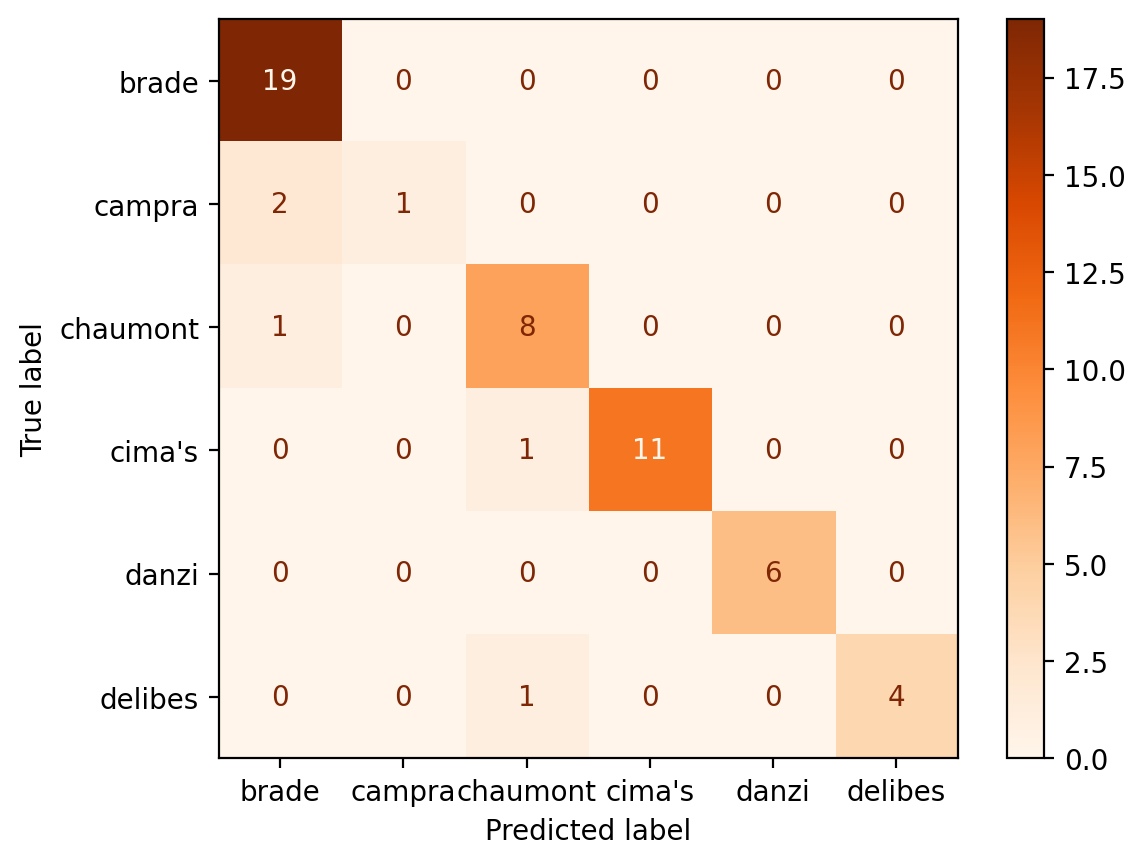

In [ ]:
# Gradient Boosting
gradient_model = GradientBoostingClassifier(n_estimators=120, learning_rate=0.2, random_state=42)

# The measure of the overall model performance
# Thus to track the start and ending time of the model and its memory usage
# Note with the import of tracemalloc; it allows to track the training time for the model in use
start_time = time.time()
tracemalloc.start()
gradient_model.fit(X_train, y_train)
training_time = time.time() - start_time
_, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
y_pred_gb = gradient_model.predict(X_test)
# Thus, note that the import of tracemalloc allows time tracking of the performance based on model

# Model performance based on its accruacy; how well to its classifcation
gb_accuracy = gradient_model.score(X_test, y_test)
gb_cm = confusion_matrix(y_test, y_pred_gb)

# Results to be provided in output
print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")
print(f"Gradient Boosting Training Time: {training_time:.2f} seconds")
print(f"Gradient Boosting Training Memory Usage: {peak / 10**6:.2f} MB (peak)")

# Visual of the CM (confusion matrix)
ConfusionMatrixDisplay(confusion_matrix=gb_cm, display_labels=encoder.classes_).plot(cmap="Oranges")

**Visual Output Explanation;**

 Now, with our new model, Gradient Boosting, the visual confusion matrix provides a picture of whether this model performs well in the classification of classical music among composers, long term short, let go over our confusion matrix associated with this machine learning model, therefore, of the given overview, class 0; 19 classified correctly, class 1; 1 classified correctly with 2 misclassified, class 2; 8 classifieds correctly with 1 misclassified, class 3; 11 classified correctly with 1 classified incorrectly, class 4; 6 classified correctly and 1 misclassified, and lastly class 5; 4 were classified correctly with one misclassified. This model has also been misclassified less than, while the majority of its performance in classification of correctness is strong.

**Logistic Regression**

Logistic Regression Accuracy: 0.9074
Logistic Regression Training Time: 12.89 seconds
Logistic Regression Training Memory Usage: 73.20 MB (peak)


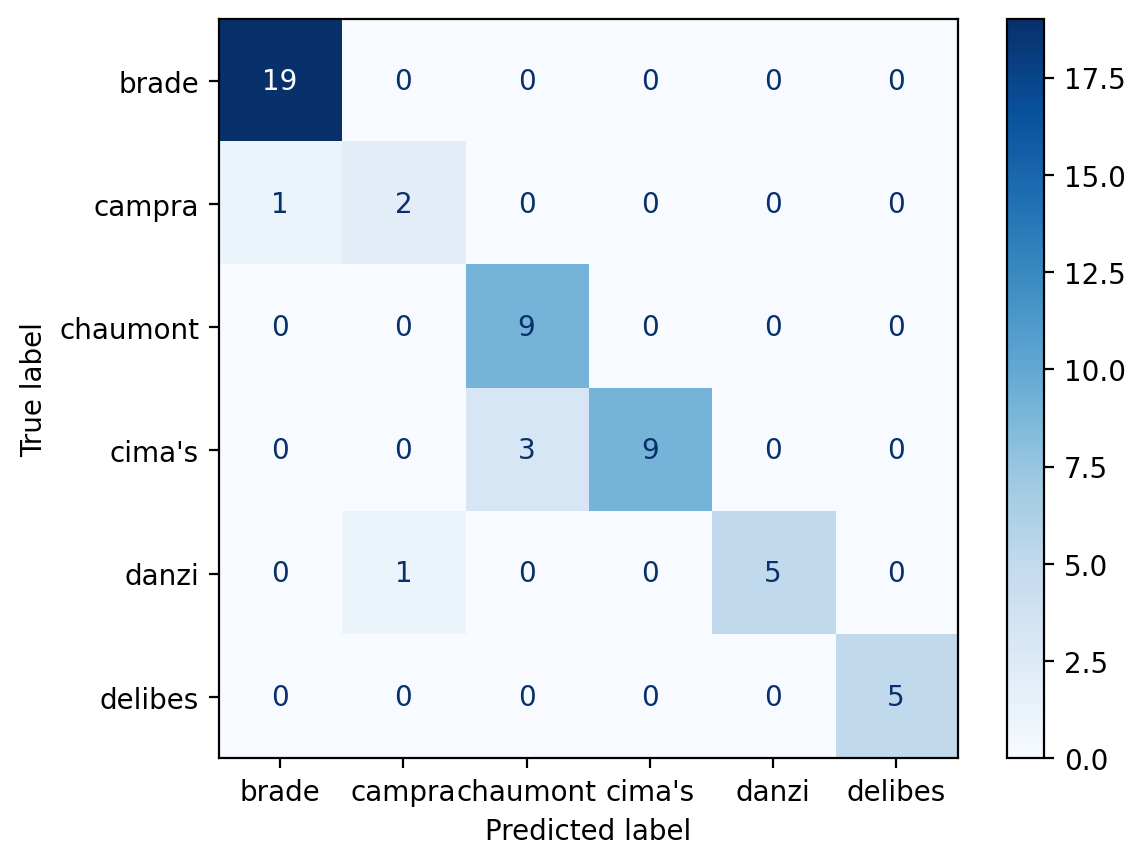

In [ ]:
# Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# The measure of the overall model performance
# Thus to track the start and ending time of the model and its memory usage
# Note with the import of tracemalloc; it allows to track the training time for the model in use
start_time = time.time()
tracemalloc.start()
logistic_model.fit(X_train, y_train)
training_time = time.time() - start_time
_, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
y_pred_lr = logistic_model.predict(X_test)
# Thus, note that the import of tracemalloc allows time tracking of the performance based on model

# Model performance based on its accruacy; how well to its classifcation
lr_accuracy = logistic_model.score(X_test, y_test)
lr_cm = confusion_matrix(y_test, y_pred_lr)

# Results to be provided in output
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Logistic Regression Training Time: {training_time:.2f} seconds")
print(f"Logistic Regression Training Memory Usage: {peak / 10**6:.2f} MB (peak)")

# Visual of the CM (confusion matrix)
ConfusionMatrixDisplay(confusion_matrix=lr_cm, display_labels=encoder.classes_).plot(cmap="Blues")

**Visual Output Explanation;**

With this overall visual of confusion matrix specifically for Support Vector Machine, the way I’m looking at this matrix, on our true positive (TP), diagonally, and the outer predicted classes, there is a very minimal misclassification, to advance towards this visual, allow me to explain and go over the classification that is correctly classified and what has been misclassified from each composer, therefore, class 0; 19 classified correctly, class 1; 3 classified correctly, class 2; 9 classifieds correctly, class 3; 10 classified correctly with 1 classified incorrectly, class 4; 5 classified correctly and 1 misclassified, and lastly class 5; 4 were classified correctly with 1 misclassified. The visual interpretation that I have went over shows where the correct decisions were made and what were the struggles/misclassifications that the model has encountered. But this model is very solid knowing that the struggle is very minimum.

#### **Barplot visual of all implemented models (comparsion view; optional)**

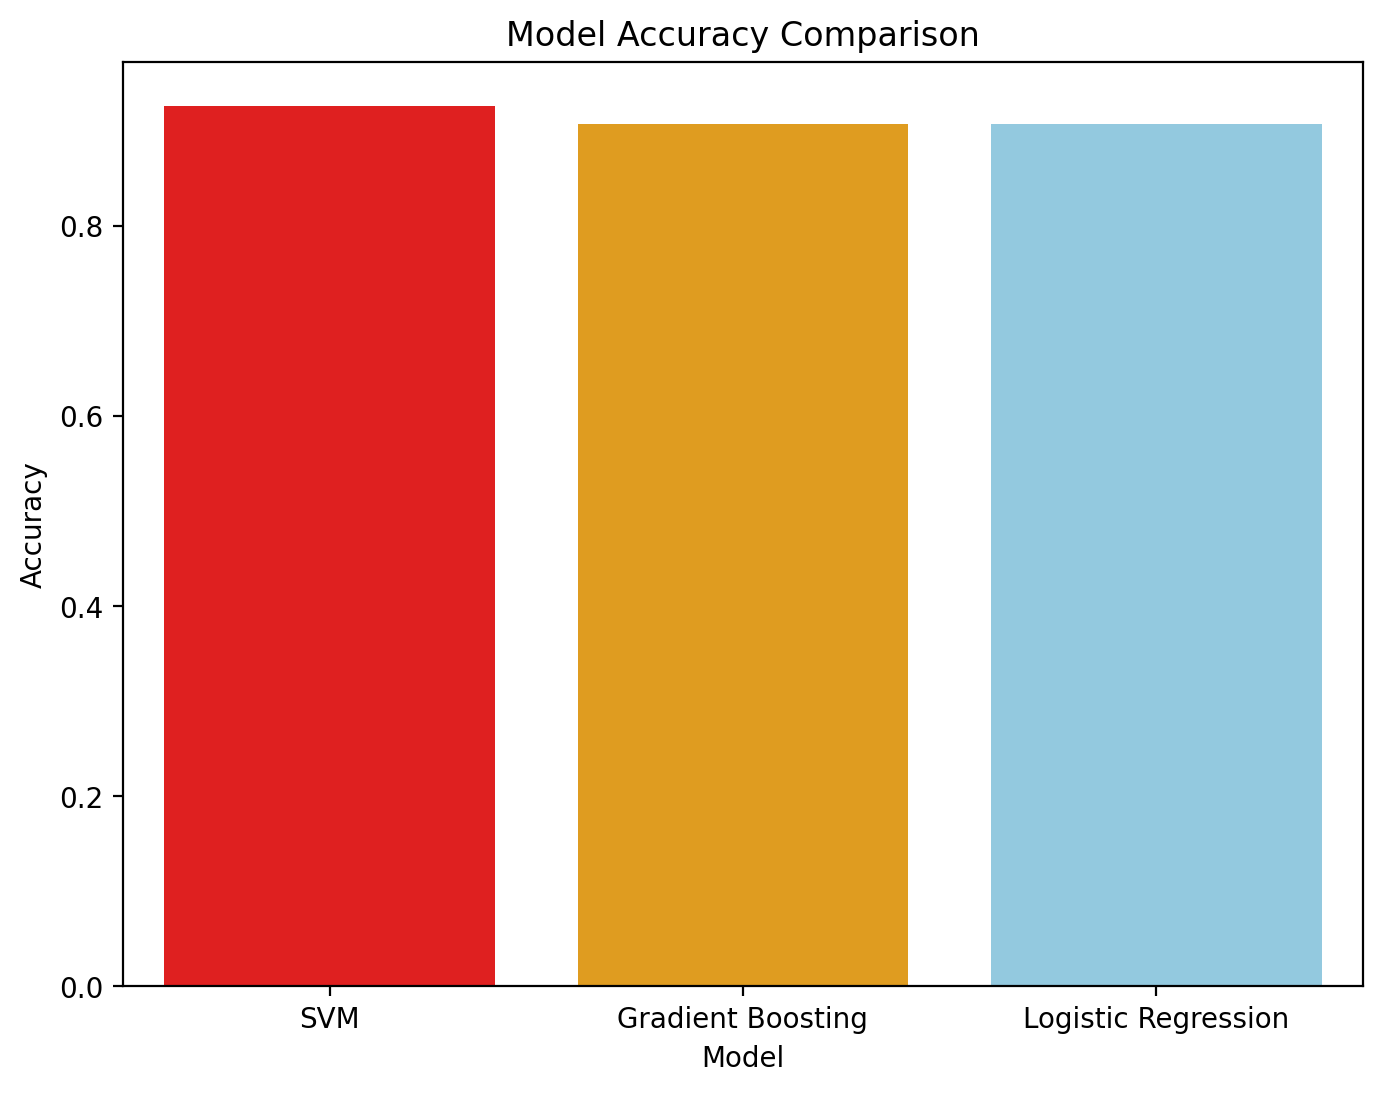

In [ ]:
# Viusal implementation of our selected models in comparsion via Barplot
models = ['SVM', 'Gradient Boosting', 'Logistic Regression']
accuracies = [svm_accuracy, lr_accuracy, gb_accuracy]

colors = ['red', 'orange', 'skyblue']

plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies, hue=models, palette=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

Thus, with this barplot visual, you are then able to see, the comparison difference in accuracy scores, though the difference range of its accuracy (percentage-wise), though shown in decimal form, is very slight differences.

**Note for myself ~ future revisits;** will explore different meaningful attributes, and to use machine learning models that differs from what i choose, to therefore compare further models, goal to exceed my current accuracy scores and performance further than it is right now